In [1]:
import tensorflow as tf

from keras import optimizers
from keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications import ResNet50, DenseNet201
from keras.applications import resnet, densenet

import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import pandas as pd
!pip install split-folders

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications import ResNet50, DenseNet201
from keras.applications import resnet, densenet

Loading Data

In [3]:
path="/kaggle/input/combined-project-data/Data"

In [4]:
import splitfolders
splitfolders.ratio(path, output="/kaggle/working/", 
                   seed=1, ratio=(.8,.2), 
                   group_prefix=None,)

Copying files: 900 files [00:04, 205.17 files/s]


In [5]:
# train_datagen = ImageDataGenerator()
train_ds = tf.keras.utils.image_dataset_from_directory(path)


Found 900 files belonging to 4 classes.


In [6]:
class_labels=train_ds.class_names
print(class_labels)

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma']


In [7]:
def prepare_name_with_labels(folder_name,Y, dataset_type='train'):
    """ Prepare the file names (X) and the class labels (Y) from folder location of images.

        Args:
            folder_name: str
                Source folder's path

    """
#     Y=[]
    source_files = os.listdir(os.path.join("/kaggle/working/", dataset_type, folder_name))
    y_label = 0
    for i in range(len(class_labels)):
        if(folder_name == class_labels[i]):
            y_label = i
    for val in source_files:
        Y.append(y_label)

In [8]:
def load_images_from_folder(X,folder,size=(224,224)):
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img=cv2.resize(img,size)
            X.append(img)
    print(len(X))

In [9]:
X=[]
for i in range(len(class_labels)):
    folder=os.path.join("/kaggle/working/train/"+class_labels[i])
    load_images_from_folder(X,folder)
#     X.append(image)
    print("\n",i)

260

 0
390

 1
517

 2
718

 3


In [10]:
Y=[]
for i in range(len(class_labels)):
    prepare_name_with_labels(class_labels[i],Y)
    print(i)

0
1
2
3


In [11]:
X_test=[]
for i in range(len(class_labels)):
    folder=os.path.join("/kaggle/working/val/"+class_labels[i])
    load_images_from_folder(X_test,folder)
#     X.append(image)
    print("\n",i)

66

 0
99

 1
131

 2
182

 3


In [12]:
Y_test=[]
for i in range(len(class_labels)):
    prepare_name_with_labels(class_labels[i],Y_test,dataset_type='val')
    print(i)

0
1
2
3


In [13]:
X = np.asarray(X)
Y = np.asarray(Y)
X_test=np.asarray(X_test)
Y_test=np.asarray(Y_test)
print(X.shape)
print(Y.shape)
print(X_test.shape)
print(Y_test.shape)

(718, 224, 224, 3)
(718,)
(182, 224, 224, 3)
(182,)


Preprocessing Data

In [14]:
from sklearn.preprocessing import OneHotEncoder
drop_binary_enc = OneHotEncoder().fit(Y.reshape(-1,1))
Y_label=drop_binary_enc.transform(Y.reshape(-1,1)).toarray()
print(Y_label.shape)

(718, 4)


In [15]:
from sklearn.preprocessing import OneHotEncoder
drop_binary_enc_test = OneHotEncoder().fit(Y_test.reshape(-1,1))
Y_label_test=drop_binary_enc_test.transform(Y_test.reshape(-1,1)).toarray()
print(Y_label_test.shape)

(182, 4)


In [16]:
train_datagen = ImageDataGenerator(rescale=1./255, dtype='float32')
valid_datagen = ImageDataGenerator(rescale=1./255, dtype='float32')
test_datagen = ImageDataGenerator(rescale=1./255, dtype='float32')

In [17]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [18]:
image_shape = (224,224,3)
N_CLASSES = 4
BATCH_SIZE = 32
resnet50v2_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=image_shape, weights="imagenet", classes=4)
    # Freeze the pretrained weights
resnet50v2_model.trainable =False

94668760/94668760 [==============================] - 0s 0us/step


In [19]:
early_stopping = EarlyStopping(verbose=1, patience=12)

In [20]:
def create_new_model(n):
    n=str(n)
    model = Sequential()
    model.add(resnet50v2_model)
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(N_CLASSES, activation='softmax'))
    model.compile(optimizer=optimizers.Adam(learning_rate= 0.0001, decay= 1e-5), loss = 'categorical_crossentropy', metrics = ['acc'])
    
    checkpointer = ModelCheckpoint(filepath='./resnet50v2_model'+n+'.hdf5',
                            monitor='val_acc', verbose = 1,
                            save_best_only=True)
    return model,checkpointer


Results for fold 1
Epoch 1/25


2023-04-18 07:22:44.438685: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.3670 - acc: 0.3972
Epoch 1: val_acc improved from -inf to 0.61806, saving model to ./resnet50v2_model1.hdf5
18/18 [==============================] - 11s 190ms/step - loss: 1.3670 - acc: 0.3972 - val_loss: 0.9070 - val_acc: 0.6181
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.6183 - acc: 0.7544
Epoch 2: val_acc improved from 0.61806 to 0.70833, saving model to ./resnet50v2_model1.hdf5
18/18 [==============================] - 2s 106ms/step - loss: 0.6183 - acc: 0.7544 - val_loss: 0.6766 - val_acc: 0.7083
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.3424 - acc: 0.8850
Epoch 3: val_acc improved from 0.70833 to 0.78472, saving model to ./resnet50v2_model1.hdf5
18/18 [==============================] - 2s 108ms/step - loss: 0.3424 - acc: 0.8850 - val_loss: 0.5438 - val_acc: 0.7847
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.2127 - acc: 0.9460
Epoch 4: val_acc i

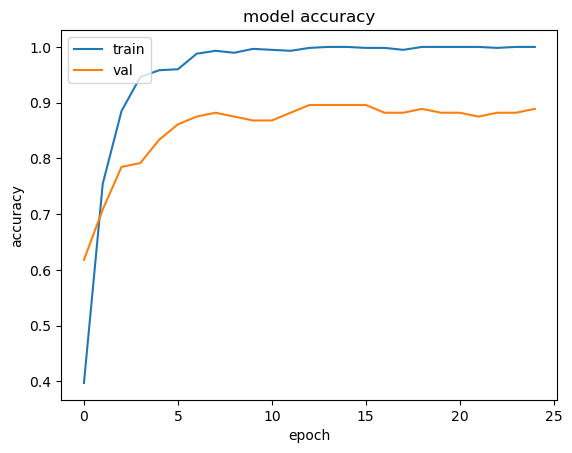

Model metrics for Round 1

6/6 [==============================] - 1s 105ms/step - loss: 0.4324 - acc: 0.8791
Accuracy 87.91208863258362
Loss 0.4324466586112976

Results for fold 2
Epoch 1/25


2023-04-18 07:23:36.018218: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.2914 - acc: 0.4373
Epoch 1: val_acc improved from -inf to 0.63194, saving model to ./resnet50v2_model2.hdf5
18/18 [==============================] - 6s 155ms/step - loss: 1.2914 - acc: 0.4373 - val_loss: 0.9073 - val_acc: 0.6319
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.6059 - acc: 0.7683
Epoch 2: val_acc improved from 0.63194 to 0.81250, saving model to ./resnet50v2_model2.hdf5
18/18 [==============================] - 2s 107ms/step - loss: 0.6059 - acc: 0.7683 - val_loss: 0.5852 - val_acc: 0.8125
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.3474 - acc: 0.8780
Epoch 3: val_acc improved from 0.81250 to 0.84028, saving model to ./resnet50v2_model2.hdf5
18/18 [==============================] - 2s 106ms/step - loss: 0.3474 - acc: 0.8780 - val_loss: 0.4674 - val_acc: 0.8403
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.2276 - acc: 0.9425
Epoch 4: val_acc im

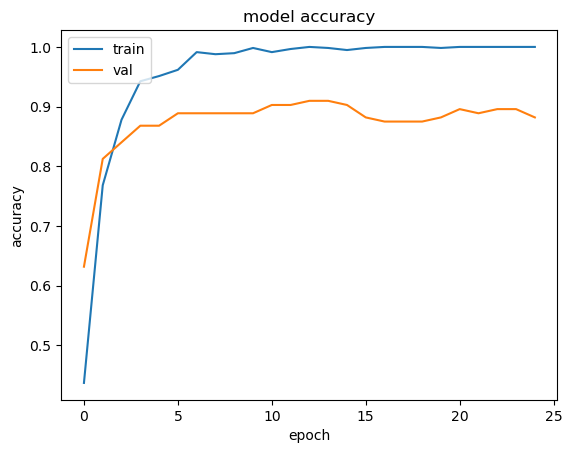

Model metrics for Round 2

6/6 [==============================] - 0s 57ms/step - loss: 0.3112 - acc: 0.9451
Accuracy 94.50549483299255
Loss 0.31119874119758606

Results for fold 3
Epoch 1/25


2023-04-18 07:24:22.462359: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.3108 - acc: 0.4355
Epoch 1: val_acc improved from -inf to 0.61111, saving model to ./resnet50v2_model3.hdf5
18/18 [==============================] - 6s 177ms/step - loss: 1.3108 - acc: 0.4355 - val_loss: 1.0159 - val_acc: 0.6111
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.6163 - acc: 0.7544
Epoch 2: val_acc improved from 0.61111 to 0.69444, saving model to ./resnet50v2_model3.hdf5
18/18 [==============================] - 2s 105ms/step - loss: 0.6163 - acc: 0.7544 - val_loss: 0.7601 - val_acc: 0.6944
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.3640 - acc: 0.8780
Epoch 3: val_acc improved from 0.69444 to 0.75000, saving model to ./resnet50v2_model3.hdf5
18/18 [==============================] - 2s 104ms/step - loss: 0.3640 - acc: 0.8780 - val_loss: 0.6400 - val_acc: 0.7500
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.2431 - acc: 0.9268
Epoch 4: val_acc im

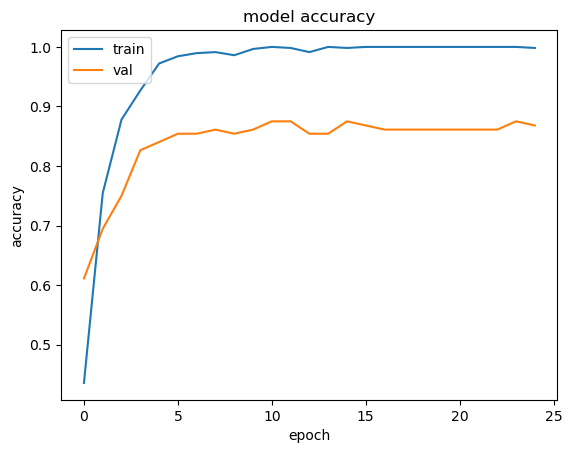

Model metrics for Round 3

6/6 [==============================] - 0s 58ms/step - loss: 0.3775 - acc: 0.8846
Accuracy 88.46153616905212
Loss 0.3774913251399994

Results for fold 4
Epoch 1/25


2023-04-18 07:25:09.392821: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.3239 - acc: 0.4330
Epoch 1: val_acc improved from -inf to 0.59441, saving model to ./resnet50v2_model4.hdf5
18/18 [==============================] - 6s 173ms/step - loss: 1.3239 - acc: 0.4330 - val_loss: 1.1094 - val_acc: 0.5944
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.5943 - acc: 0.7809
Epoch 2: val_acc improved from 0.59441 to 0.71329, saving model to ./resnet50v2_model4.hdf5
18/18 [==============================] - 2s 106ms/step - loss: 0.5943 - acc: 0.7809 - val_loss: 0.7437 - val_acc: 0.7133
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.3649 - acc: 0.8643
Epoch 3: val_acc improved from 0.71329 to 0.78322, saving model to ./resnet50v2_model4.hdf5
18/18 [==============================] - 2s 104ms/step - loss: 0.3649 - acc: 0.8643 - val_loss: 0.5955 - val_acc: 0.7832
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.2247 - acc: 0.9339
Epoch 4: val_acc im

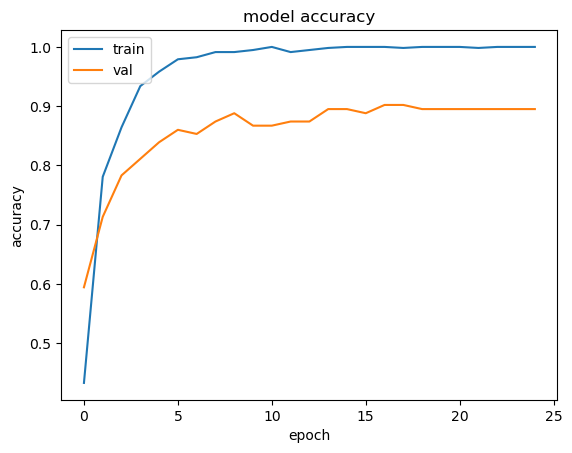

Model metrics for Round 4

6/6 [==============================] - 0s 58ms/step - loss: 0.4449 - acc: 0.8791
Accuracy 87.91208863258362
Loss 0.44487234950065613

Results for fold 5
Epoch 1/25


2023-04-18 07:25:58.455625: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.3229 - acc: 0.4243
Epoch 1: val_acc improved from -inf to 0.69930, saving model to ./resnet50v2_model5.hdf5
18/18 [==============================] - 6s 156ms/step - loss: 1.3229 - acc: 0.4243 - val_loss: 0.7854 - val_acc: 0.6993
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.6289 - acc: 0.7583
Epoch 2: val_acc improved from 0.69930 to 0.79021, saving model to ./resnet50v2_model5.hdf5
18/18 [==============================] - 2s 109ms/step - loss: 0.6289 - acc: 0.7583 - val_loss: 0.5661 - val_acc: 0.7902
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.3839 - acc: 0.8730
Epoch 3: val_acc improved from 0.79021 to 0.86713, saving model to ./resnet50v2_model5.hdf5
18/18 [==============================] - 2s 133ms/step - loss: 0.3839 - acc: 0.8730 - val_loss: 0.4244 - val_acc: 0.8671
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.2534 - acc: 0.9304
Epoch 4: val_acc im

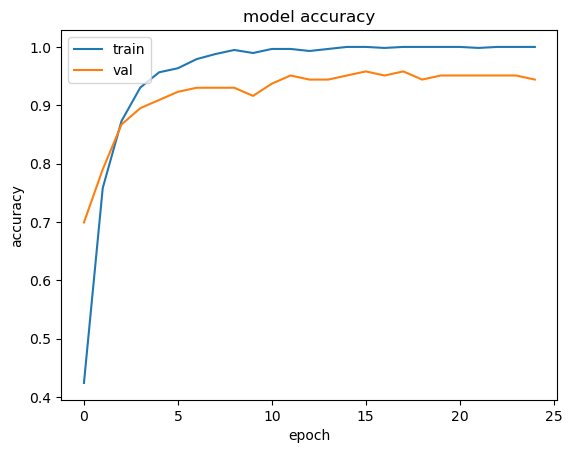

Model metrics for Round 5

6/6 [==============================] - 0s 59ms/step - loss: 0.3651 - acc: 0.8956
Accuracy 89.56043720245361
Loss 0.3650505542755127


In [23]:
fold_num = 0
skf_acc=[]
skf_loss=[]
for train_index, val_index in kfold.split(X, Y):
    # First cut all images from validation to train (if any exists)
#     transfer_all_class_between_folders('validation', 'train', 1.0)
    fold_num += 1
    print("\nResults for fold", fold_num)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y_label[train_index], Y_label[val_index]
#     print("\n",X_train.shape,Y_train.shape)
#     print(X_val.shape,Y_val.shape)
    train_generator = train_datagen.flow(X_train,
                                         Y_train,
                                         batch_size = BATCH_SIZE)
    valid_generator = valid_datagen.flow(X_val,
                                         Y_val,
                                         batch_size = BATCH_SIZE)
    test_generator = test_datagen.flow(X_test,
                                       Y_label_test,
                                       batch_size = BATCH_SIZE)

    model,checkpointer=create_new_model(fold_num)
    # fit model
    history= model.fit(train_generator,
                            epochs = 25,
                            verbose = 1,
                            validation_data = valid_generator,
                            callbacks = [checkpointer, early_stopping])
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    print("Model metrics for Round "+str(fold_num)+"\n")
    result=model.evaluate(test_generator)
    print("Accuracy",result[1]*100)
    print("Loss",result[0])
    skf_acc.append(result[1])
    skf_loss.append(result[0])

In [24]:
model2=tf.keras.models.load_model("/kaggle/working/resnet50v2_model4.hdf5")

In [25]:
model2.evaluate(test_generator)

6/6 [==============================] - 1s 60ms/step - loss: 0.4315 - acc: 0.8681


[0.4314665198326111, 0.8681318759918213]

Holdout Method

In [26]:
from sklearn.model_selection import train_test_split
X_train_,X_val_,Y_train_,Y_val_=train_test_split(X,Y_label,train_size=0.8)

In [27]:
print(X_train_.shape,Y_train.shape)
print(X_val_.shape,Y_val.shape)

(574, 224, 224, 3) (575, 4)
(144, 224, 224, 3) (143, 4)


Epoch 1/25


2023-04-18 07:50:26.461933: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.2460 - acc: 0.4843
Epoch 1: val_acc improved from -inf to 0.67361, saving model to ./resnet50v2_modelx.hdf5
18/18 [==============================] - 6s 159ms/step - loss: 1.2460 - acc: 0.4843 - val_loss: 0.8710 - val_acc: 0.6736
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.5910 - acc: 0.7770
Epoch 2: val_acc improved from 0.67361 to 0.75694, saving model to ./resnet50v2_modelx.hdf5
18/18 [==============================] - 2s 102ms/step - loss: 0.5910 - acc: 0.7770 - val_loss: 0.6020 - val_acc: 0.7569
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.3400 - acc: 0.8885
Epoch 3: val_acc improved from 0.75694 to 0.82639, saving model to ./resnet50v2_modelx.hdf5
18/18 [==============================] - 2s 105ms/step - loss: 0.3400 - acc: 0.8885 - val_loss: 0.4924 - val_acc: 0.8264
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.2719 - acc: 0.8972
Epoch 4: val_acc im

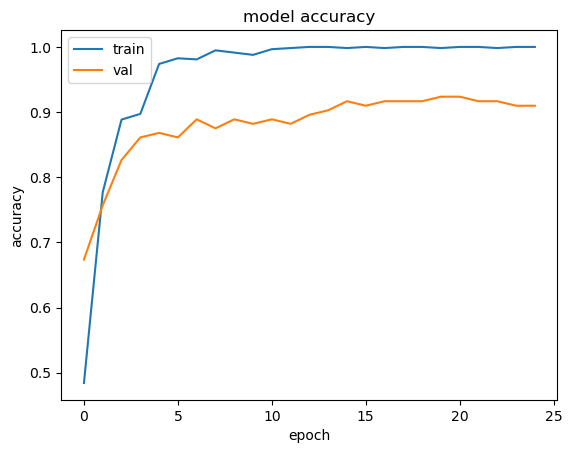

In [29]:
train_generator = train_datagen.flow(X_train_,
                                         Y_train_,
                                         batch_size = BATCH_SIZE)
valid_generator = valid_datagen.flow(X_val_,
                                     Y_val_,
                                     batch_size = BATCH_SIZE)
test_generator = test_datagen.flow(X_test,
                                   Y_label_test,
                                   batch_size = BATCH_SIZE)
#create a new model
model,checkpointer=create_new_model('x')
# fit model
history= model.fit(train_generator,
                        epochs = 25,
                        verbose = 1,
                        validation_data = valid_generator,
                        callbacks = [checkpointer, early_stopping])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
score=model.evaluate(test_generator)
print("Accuracy",score[1]*100)
print("Loss",score[0])

6/6 [==============================] - 0s 58ms/step - loss: 0.3451 - acc: 0.8846
Accuracy 88.46153616905212
Loss 0.3451228439807892


In [31]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True,random_state=1)

Results for fold 1.1
Epoch 1/25


2023-04-18 07:51:13.196292: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.3102 - acc: 0.4477
Epoch 1: val_acc improved from -inf to 0.58333, saving model to ./resnet50v2_model1.1.hdf5
18/18 [==============================] - 6s 154ms/step - loss: 1.3102 - acc: 0.4477 - val_loss: 1.0209 - val_acc: 0.5833
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.6731 - acc: 0.7352
Epoch 2: val_acc improved from 0.58333 to 0.79861, saving model to ./resnet50v2_model1.1.hdf5
18/18 [==============================] - 2s 104ms/step - loss: 0.6731 - acc: 0.7352 - val_loss: 0.6320 - val_acc: 0.7986
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.3710 - acc: 0.8833
Epoch 3: val_acc improved from 0.79861 to 0.84028, saving model to ./resnet50v2_model1.1.hdf5
18/18 [==============================] - 2s 103ms/step - loss: 0.3710 - acc: 0.8833 - val_loss: 0.4680 - val_acc: 0.8403
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.2517 - acc: 0.9268
Epoch 4: val_

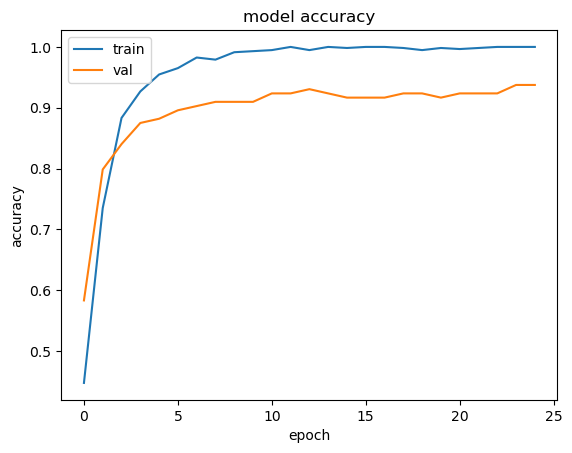

Model metrics for Round 1.1

6/6 [==============================] - 0s 58ms/step - loss: 0.3698 - acc: 0.8791
Accuracy:  87.91208863258362
Loss:  0.3698241710662842
Results for fold 2.1
Epoch 1/25


2023-04-18 07:52:01.279412: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.2446 - acc: 0.4756
Epoch 1: val_acc improved from -inf to 0.66667, saving model to ./resnet50v2_model2.1.hdf5
18/18 [==============================] - 6s 156ms/step - loss: 1.2446 - acc: 0.4756 - val_loss: 0.8164 - val_acc: 0.6667
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.5989 - acc: 0.7648
Epoch 2: val_acc improved from 0.66667 to 0.76389, saving model to ./resnet50v2_model2.1.hdf5
18/18 [==============================] - 2s 107ms/step - loss: 0.5989 - acc: 0.7648 - val_loss: 0.6083 - val_acc: 0.7639
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.3430 - acc: 0.8833
Epoch 3: val_acc improved from 0.76389 to 0.83333, saving model to ./resnet50v2_model2.1.hdf5
18/18 [==============================] - 2s 104ms/step - loss: 0.3430 - acc: 0.8833 - val_loss: 0.4916 - val_acc: 0.8333
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.2081 - acc: 0.9408
Epoch 4: val_

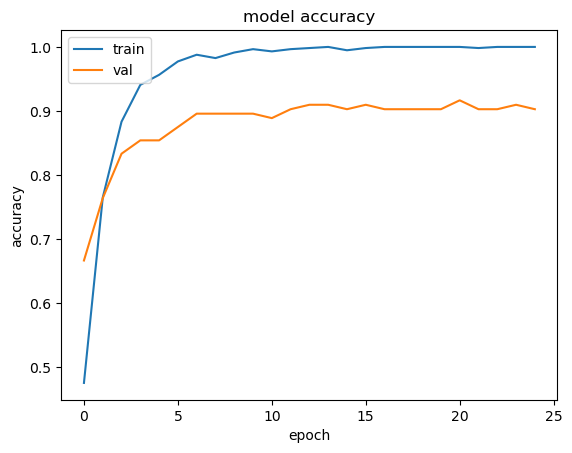

Model metrics for Round 2.1

6/6 [==============================] - 0s 57ms/step - loss: 0.3932 - acc: 0.9011
Accuracy:  90.1098906993866
Loss:  0.39319196343421936
Results for fold 3.1
Epoch 1/25


2023-04-18 07:52:50.816721: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.2687 - acc: 0.4390
Epoch 1: val_acc improved from -inf to 0.61111, saving model to ./resnet50v2_model3.1.hdf5
18/18 [==============================] - 6s 158ms/step - loss: 1.2687 - acc: 0.4390 - val_loss: 1.0250 - val_acc: 0.6111
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.5468 - acc: 0.7840
Epoch 2: val_acc improved from 0.61111 to 0.70139, saving model to ./resnet50v2_model3.1.hdf5
18/18 [==============================] - 2s 104ms/step - loss: 0.5468 - acc: 0.7840 - val_loss: 0.7878 - val_acc: 0.7014
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.3204 - acc: 0.9007
Epoch 3: val_acc improved from 0.70139 to 0.78472, saving model to ./resnet50v2_model3.1.hdf5
18/18 [==============================] - 2s 108ms/step - loss: 0.3204 - acc: 0.9007 - val_loss: 0.6415 - val_acc: 0.7847
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.2196 - acc: 0.9373
Epoch 4: val_

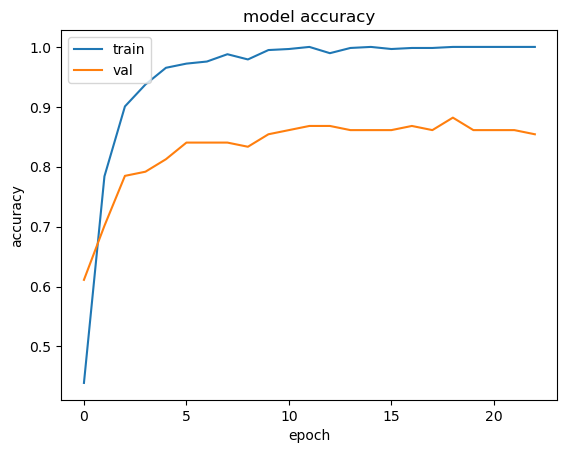

Model metrics for Round 3.1

6/6 [==============================] - 0s 60ms/step - loss: 0.3629 - acc: 0.9121
Accuracy:  91.20879173278809
Loss:  0.3629342317581177
Results for fold 4.1
Epoch 1/25


2023-04-18 07:53:35.156296: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.2773 - acc: 0.4765
Epoch 1: val_acc improved from -inf to 0.66434, saving model to ./resnet50v2_model4.1.hdf5
18/18 [==============================] - 6s 154ms/step - loss: 1.2773 - acc: 0.4765 - val_loss: 0.7394 - val_acc: 0.6643
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.6501 - acc: 0.7426
Epoch 2: val_acc improved from 0.66434 to 0.83916, saving model to ./resnet50v2_model4.1.hdf5
18/18 [==============================] - 2s 105ms/step - loss: 0.6501 - acc: 0.7426 - val_loss: 0.5102 - val_acc: 0.8392
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.3586 - acc: 0.8783
Epoch 3: val_acc improved from 0.83916 to 0.84615, saving model to ./resnet50v2_model4.1.hdf5
18/18 [==============================] - 2s 106ms/step - loss: 0.3586 - acc: 0.8783 - val_loss: 0.4316 - val_acc: 0.8462
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.2494 - acc: 0.9374
Epoch 4: val_

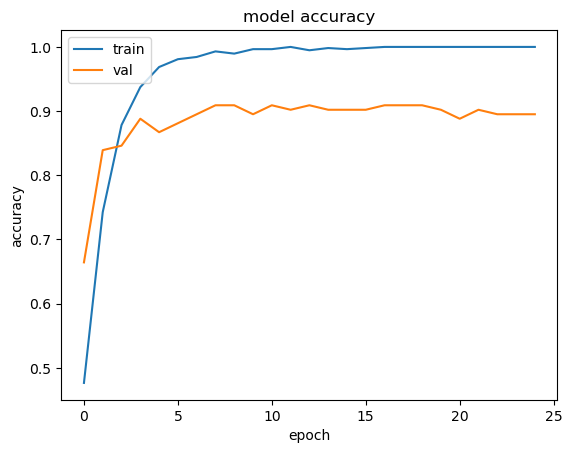

Model metrics for Round 4.1

6/6 [==============================] - 0s 60ms/step - loss: 0.3661 - acc: 0.9176
Accuracy:  91.75823926925659
Loss:  0.36606425046920776
Results for fold 5.1
Epoch 1/25


2023-04-18 07:54:21.113218: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.2403 - acc: 0.4678
Epoch 1: val_acc improved from -inf to 0.58042, saving model to ./resnet50v2_model5.1.hdf5
18/18 [==============================] - 6s 155ms/step - loss: 1.2403 - acc: 0.4678 - val_loss: 1.0690 - val_acc: 0.5804
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.6256 - acc: 0.7565
Epoch 2: val_acc improved from 0.58042 to 0.68531, saving model to ./resnet50v2_model5.1.hdf5
18/18 [==============================] - 2s 106ms/step - loss: 0.6256 - acc: 0.7565 - val_loss: 0.8169 - val_acc: 0.6853
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.3491 - acc: 0.8713
Epoch 3: val_acc improved from 0.68531 to 0.74825, saving model to ./resnet50v2_model5.1.hdf5
18/18 [==============================] - 2s 110ms/step - loss: 0.3491 - acc: 0.8713 - val_loss: 0.6655 - val_acc: 0.7483
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.2259 - acc: 0.9304
Epoch 4: val_

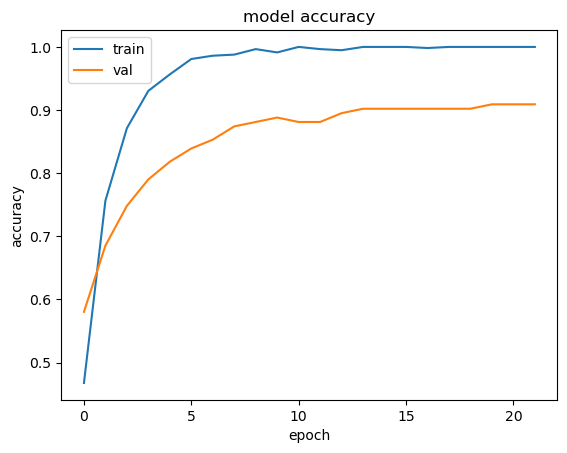

Model metrics for Round 5.1

6/6 [==============================] - 0s 60ms/step - loss: 0.4354 - acc: 0.8791
Accuracy:  87.91208863258362
Loss:  0.4354054033756256


In [32]:
fold_num = 0.1
kf_acc=[]
kf_loss=[]
for train_index, val_index in kf.split(X, Y_label):
    # First cut all images from validation to train (if any exists)
#     transfer_all_class_between_folders('validation', 'train', 1.0)
    fold_num += 1
    print("Results for fold", fold_num)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y_label[train_index], Y_label[val_index]
#     print("\n",X_train.shape,Y_train.shape)
#     print(X_val.shape,Y_val.shape)
    train_generator = train_datagen.flow(X_train,
                                         Y_train,
                                         batch_size = BATCH_SIZE)
    valid_generator = valid_datagen.flow(X_val,
                                         Y_val,
                                         batch_size = BATCH_SIZE)
    test_generator = test_datagen.flow(X_test,
                                       Y_label_test,
                                       batch_size = BATCH_SIZE)

    model,checkpointer=create_new_model(fold_num)
    # fit model
    history= model.fit(train_generator,
                            epochs = 25,
                            verbose = 1,
                            validation_data = valid_generator,
                            callbacks = [checkpointer, early_stopping])
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    print("Model metrics for Round "+str(fold_num)+"\n")
    result=model.evaluate(test_generator)
    print("Accuracy: ",result[1]*100)
    print("Loss: ",result[0])
    kf_acc.append(result[1])
    kf_loss.append(result[0])

In [33]:
skf_acc=np.array(skf_acc)
skf_loss=np.array(skf_loss)
kf_acc=np.array(kf_acc)
kf_loss=np.array(kf_loss)

print("Accuracy and loss for StratifiedKfold")
print("Accuracy: ",sum(skf_acc)/len(skf_acc)*100)
print("Loss: ",sum(skf_loss)/len(skf_loss))
print("\nAccuracy and loss for Kfold")
print("Accuracy: ",sum(kf_acc)/len(kf_acc)*100)
print("Loss: ",sum(kf_loss)/len(kf_loss))
print("\nAccuracy and loss for Holdout")
print("Accuracy: ",score[1]*100)
print("Loss: ",score[0])

Accuracy and loss for StratifiedKfold
Accuracy:  89.6703290939331
Loss:  0.3862119257450104

Accuracy and loss for Kfold
Accuracy:  89.7802197933197
Loss:  0.38548400402069094

Accuracy and loss for Holdout
Accuracy:  88.46153616905212
Loss:  0.3451228439807892
